In [22]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from data import FloodEventDataset
from utils import file_utils

### Dataset Visualization

In [23]:
config_path = 'configs/experiment/gat_config.yaml'
config = file_utils.read_yaml_file(config_path)

In [24]:
mode = 'test' # 'train' or 'test'

dataset_parameters = config['dataset_parameters']
if mode == 'train':
    dataset_summary_file = dataset_parameters['training']['dataset_summary_file']
    event_stats_file = dataset_parameters['training']['event_stats_file']
else: # mode == 'test'
    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    event_stats_file = dataset_parameters['testing']['event_stats_file']

delta_t = dataset_parameters['timestep_interval']
dataset = FloodEventDataset(
    mode=mode,
    root_dir=dataset_parameters['root_dir'],
    dataset_summary_file=dataset_summary_file,
    nodes_shp_file=dataset_parameters['nodes_shp_file'],
    edges_shp_file=dataset_parameters['edges_shp_file'],
    event_stats_file=event_stats_file,
    features_stats_file=dataset_parameters['features_stats_file'],
    previous_timesteps=dataset_parameters['previous_timesteps'],
    normalize=dataset_parameters['normalize'],
    timestep_interval=delta_t,
    spin_up_timesteps=dataset_parameters['spin_up_timesteps'],
    timesteps_from_peak=dataset_parameters['timesteps_from_peak'],
    inflow_boundary_nodes=dataset_parameters['inflow_boundary_nodes'],
    outflow_boundary_nodes=dataset_parameters['outflow_boundary_nodes'],
    with_global_mass_loss=False,
    with_local_mass_loss=False,
    force_reload=True,
)

Processing Flood Event Dataset...
Saved constant values to data\datasets\processed\constant_values.npz
Saved dynamic values for event 13 to data\datasets\processed\dynamic_values_event_13.npz
Saved dynamic values for event 14 to data\datasets\processed\dynamic_values_event_14.npz
Saved dynamic values for event 15 to data\datasets\processed\dynamic_values_event_15.npz
Saved dynamic values for event 16 to data\datasets\processed\dynamic_values_event_16.npz
Saved event stats to data\datasets\processed\test_event_stats.yaml
Saved boundary condition info to data\datasets\processed\boundary_condition_masks.npz


In [14]:
print(f'Total number of events: {len(dataset.hec_ras_run_ids)}')
print(f'Total number of timesteps: {len(dataset)}')

Total number of events: 12
Total number of timesteps: 1810


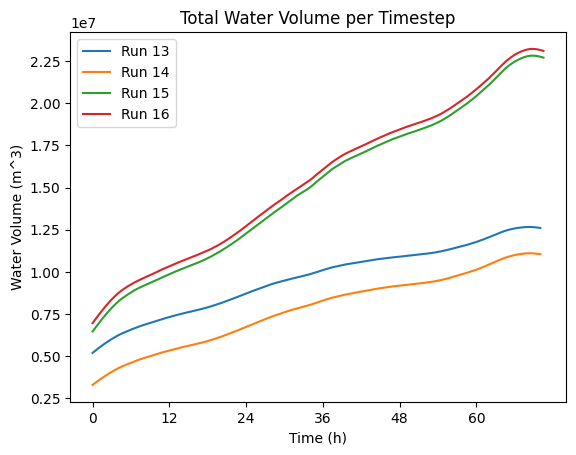

In [25]:
if mode == 'train':
    start_ts = 0
    end_ts = None
else:  # mode == 'test'
    rollout_start = config['testing_parameters']['rollout_start']
    rollout_timesteps = config['testing_parameters']['rollout_timesteps']
    start_ts = rollout_start
    end_ts = (start_ts + rollout_timesteps) if rollout_timesteps is not None else None

delta_t_in_hours = delta_t / 3600
num_events = len(dataset.hec_ras_run_ids)
dynamic_nodes_paths = dataset.processed_paths[4:(num_events + 4)]

longest_hours_elapsed = []
for run_id, path in zip(dataset.hec_ras_run_ids, dynamic_nodes_paths):
    dynamic_nodes = np.load(path)['dynamic_nodes'][2:]  # Skip the first two timesteps as this is only used for previous timestep data
    water_volume_idx = FloodEventDataset.DYNAMIC_NODE_FEATURES.index('water_volume')
    water_volume = dynamic_nodes[start_ts:end_ts, :, water_volume_idx]
    water_volume = dataset.normalizer.denormalize('water_volume', water_volume)
    total_water_volume = water_volume.sum(axis=1)
    hours_elapsed = np.arange(len(total_water_volume)) * delta_t_in_hours
    plt.plot(hours_elapsed, total_water_volume, label=f'Run {run_id}')
    if len(hours_elapsed) > len(longest_hours_elapsed):
        longest_hours_elapsed = hours_elapsed

tick_interval_in_hours = 12
plt.title(f'Total Water Volume per Timestep')
plt.xlabel('Time (h)')
interval_ticks = np.arange(0, len(longest_hours_elapsed), int(tick_interval_in_hours / delta_t_in_hours))
plt.xticks(longest_hours_elapsed[interval_ticks])
plt.ylabel('Water Volume (m^3)')
plt.legend()
plt.show()

In [ ]:
def get_highest_diff_water_volume_nodes(dataset: FloodEventDataset, event_idx: int, k: int = 4) -> tuple[list, np.ndarray]:
    num_events = len(dataset.hec_ras_run_ids)
    dynamic_nodes_paths = dataset.processed_paths[3:(num_events + 3)]

    dynamic_nodes = np.load(dynamic_nodes_paths[event_idx])['dynamic_nodes']
    water_volume_idx = FloodEventDataset.DYNAMIC_NODE_FEATURES.index('water_volume')
    water_volume = dynamic_nodes[:, :, water_volume_idx]
    water_volume = dataset.normalizer.denormalize('water_volume', water_volume)
    wv_diff = np.abs(np.diff(water_volume, axis=0))
    wv_diff_per_node = wv_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(wv_diff_per_node)[-k:][::-1].tolist()
    top_k_wd_diff = wv_diff_per_node[top_k_diff_idx]
    return top_k_diff_idx, top_k_wd_diff

def get_node_df(dataset: FloodEventDataset, no_ghost: bool = True) -> gpd.GeoDataFrame:
    nodes_shp_path = dataset.raw_paths[0]
    node_df = gpd.read_file(nodes_shp_path)

    if no_ghost:
        node_df = node_df[~node_df['CC_index'].isin(dataset.boundary_condition.ghost_nodes)]

    return node_df

def plot_cell_map(node_df: gpd.GeoDataFrame, value: np.ndarray=None, cmap=None):
    default_marker_size = 1
    shared_plot_kwargs = {
        'linewidth': 0.3,
        'markersize': default_marker_size,
    }

    if value is not None:
        value_column = 'is_flooded'
        node_df[value_column] = value
        if cmap is None:
            cmap = plt.get_cmap('seismic_r') 
        markersize = (value.astype(bool).astype(int) * 10) + default_marker_size
        shared_plot_kwargs.update({
            'markersize': markersize,
            'cmap': cmap,
            'column': value_column,
            'legend': True,
            'legend_kwds': {
                'loc': 'lower right',
                'fontsize': 'x-small',
            },
        })

    node_df.plot(**shared_plot_kwargs)
    plt.axis('off')

EVENT_IDX = 0  # Change this to the desired event index
k = 4  # Number of top nodes to retrieve

top_k_diff_idx, top_k_wd_diff = get_highest_diff_water_volume_nodes(dataset, EVENT_IDX, k=k)
print('Nodes with the highest water volume difference:')
print(top_k_diff_idx)
for idx, wd in zip(top_k_diff_idx, top_k_wd_diff):
    print(f"Node {idx}: {wd:.2f} m")

node_df = get_node_df(dataset)
highlight = np.zeros(len(node_df), dtype=object)
highlight[top_k_diff_idx] = top_k_diff_idx

plot_cell_map(node_df, value=highlight, cmap='viridis')
plt.title(f'Top {k} Nodes with Highest Water Volume Difference for event {dataset.hec_ras_run_ids[EVENT_IDX]}')
plt.show()

KeyError: 'dynamic_nodes is not a file in the archive'